In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('../Pt3_Data_processing/home_structured_ewm16.csv')
df.sort_values(by='h_pg_date', inplace=True)

# Turning IDS into categorical variables
for col in df:
    if 'id' in col:
        df[col]=df[col].astype('category')
    
# Turning age into integers        
for col in [col for col in df if 'age' in col]:
    df[col] = df[col].apply(lambda x: int(x.replace(' days 00:00:00.000000000','')))
    
df.drop_duplicates(inplace=True)
try:
    df.drop(columns='Unnamed: 0', inplace=True)
except:
    print('no need')
df.columns

no need


Index(['h_pg_date', 'h_pg_season_id', 'h_pg_location', 'h_pg_type',
       'h_pg_outcome', 'h_pg_difference', 'h_pg_game_id', 'h_pg_team_id',
       'h_pg_team_abb', 'h_pg_team_city',
       ...
       'a_s3_ewm_ast_pct', 'a_s3_ewm_ast_tov', 'a_s3_ewm_ast_ratio',
       'a_s3_ewm_oreb_pct', 'a_s3_ewm_dreb_pct', 'a_s3_ewm_reb_pct',
       'a_s3_ewm_tm_tov_pct', 'a_s3_ewm_usg_pct', 'a_s3_ewm_game_score',
       'a_s3_ewm_plus_minus'],
      dtype='object', length=580)

In [5]:
name_id_remove = [col for col in df if any(c in col for c in ['_player_id','_name', '_team'])]

modelling_columns = ['h_pg_outcome', 'h_pg_difference', 'h_pg_type', 'h_pg_location'] + \
[col for col in df.loc[:,'h_pg_age_days':] if \
                     col not in name_id_remove]

X = df[modelling_columns].copy()
# X.fillna(value=0, inplace=True)

print('COVID\n',X['h_pg_outcome'][X['a_pg_date']>'2020-03-30'].value_counts(normalize=True))
print('\n2018-\n',X['h_pg_outcome'][X['a_pg_date']>'2018-08-30'].value_counts(normalize=True))
print('\n-2018\n',X['h_pg_outcome'][X['a_pg_date']<'2018-08-30'].value_counts(normalize=True))
print('\n2019-\n',X['h_pg_outcome'][X['a_pg_date']>'2019-08-30'].value_counts(normalize=True))
print('\n-2019\n',X['h_pg_outcome'][X['a_pg_date']<'2019-08-30'].value_counts(normalize=True))

X[X['a_pg_date']>'2017-08-30'].shape[0], X[X['a_pg_date']<'2017-08-30'].shape[0]

# # REMOVING FIRST YEAR OF GAMES AND POST-COVID 
# # (GAMES NOT PLAYED ON HOME COURTS, DATA CONSTRUCTION WOULD CAUSE ISSUES)
# X.drop(X[X['a_pg_date']<'2001-08-30'].index, inplace=True)
# X.drop(X[X['a_pg_date']>'2020-03-30'].index, inplace=True)

# print('\nBASELINE FOR TOTAL DATASET :\n',X['h_pg_outcome'].value_counts(normalize=True))

# print('\nDF SHAPE :\n',X.shape)

COVID
 1    0.533333
0    0.466667
Name: h_pg_outcome, dtype: float64

2018-
 1    0.571667
0    0.428333
Name: h_pg_outcome, dtype: float64

-2018
 1    0.600805
0    0.399195
Name: h_pg_outcome, dtype: float64

2019-
 1    0.549639
0    0.450361
Name: h_pg_outcome, dtype: float64

-2019
 1    0.600271
0    0.399729
Name: h_pg_outcome, dtype: float64


(3673, 21824)

In [6]:
for i in range(16):
#     PREFIX FOR NEW COLUMN NAMES
    prefix = [col for col in X if 'fgm' in col][i][:4]
#     FG%
    X[f'{prefix}_fgpct'] = X[[col for col in X if 'fgm' in col][i]] / \
    X[[col for col in X if 'fga' in col][i]]
#     FG3%
    X[f'{prefix[:-4]}_fg3pct'] = X[[col for col in X if 'fg3m' in col][i]] / \
    X[[col for col in X if 'fg3a' in col][i]]
#     FT%
    X[f'{prefix[:-4]}_ftpct'] = X[[col for col in X if 'ftm' in col][i]] / \
    X[[col for col in X if 'fta' in col][i]]
#     JOHN HOLLINGER GAMESCORE
    X[f'{prefix}_gs'] = X[f'{prefix}_ewm_pts'] + .4*X[[col for col in X if 'fgm' in col][i]] - \
    .7*X[[col for col in X if 'fga' in col][i]] - .4*(X[[col for col in X if 'fta' in col][i]] - \
                                                     X[[col for col in X if 'ftm' in col][i]]) + \
    .7*X[[col for col in X if 'oreb' in col][i]] + .3*X[[col for col in X if 'dreb' in col][i]] + \
    X[[col for col in X if '_stl' in col][i]] + .7*X[[col for col in X if 'ewm_ast' in col][i]] + \
    .7*X[[col for col in X if 'ewm_blk' in col][i]] - .4*X[[col for col in X if 'ewm_pf' in col][i]] - \
    X[[col for col in X if 'ewm_to' in col][i]]

In [7]:
# X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type',
#        'a_pg_outcome', 'a_pg_difference', 'a_pg_game_id','a_pg_date','h_pg_outcome'], inplace=True)

# X.fillna(0, inplace=True)
# y = X.pop('h_pg_difference')


# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type',
       'a_pg_outcome', 'a_pg_difference', 'a_pg_game_id'], inplace=True)

X.fillna(0, inplace=True)


X_train = X[X['a_pg_date']<'2017-08-30'].copy()
X_test = X[X['a_pg_date']>'2017-08-30'].copy()

X_train.drop(columns='a_pg_date', inplace=True)
X_test.drop(columns='a_pg_date', inplace=True)


yC_train = X_train.pop('h_pg_outcome')
yC_test = X_test.pop('h_pg_outcome')

yR_train = X_train.pop('h_pg_difference')
yR_test = X_test.pop('h_pg_difference')

In [9]:
pipe = Pipeline([('scaler', StandardScaler()),
                #('pca', PCA(n_components=500)),
                ('model', ElasticNet(max_iter=1000000))])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ElasticNet(max_iter=1000000))])

In [11]:
# model = ElasticNet(max_iter=1000000)

kf = KFold(shuffle=True)

gs_params = {'model__alpha' : np.linspace(.0001,10,11),
            'model__l1_ratio': np.linspace(0.0001,1,11)}

grid = GridSearchCV(pipe, gs_params, n_jobs=2, cv=kf, verbose=3, scoring='neg_root_mean_squared_error')

grid.fit(X_train, yR_train)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 112.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 288.8min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 290.6min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 293.1min
[Parallel(n_jobs=2)]: Done 605 out of 605 | elapsed: 299.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        ElasticNet(max_iter=1000000))]),
             n_jobs=2,
             param_grid={'model__alpha': array([1.00000e-04, 1.00009e+00, 2.00008e+00, 3.00007e+00, 4.00006e+00,
       5.00005e+00, 6.00004e+00, 7.00003e+00, 8.00002e+00, 9.00001e+00,
       1.00000e+01]),
                         'model__l1_ratio': array([1.0000e-04, 1.0009e-01, 2.0008e-01, 3.0007e-01, 4.0006e-01,
       5.0005e-01, 6.0004e-01, 7.0003e-01, 8.0002e-01, 9.0001e-01,
       1.0000e+00])},
             scoring='neg_root_mean_squared_error', verbose=3)

In [12]:
grid.best_score_

-12.026412563725135

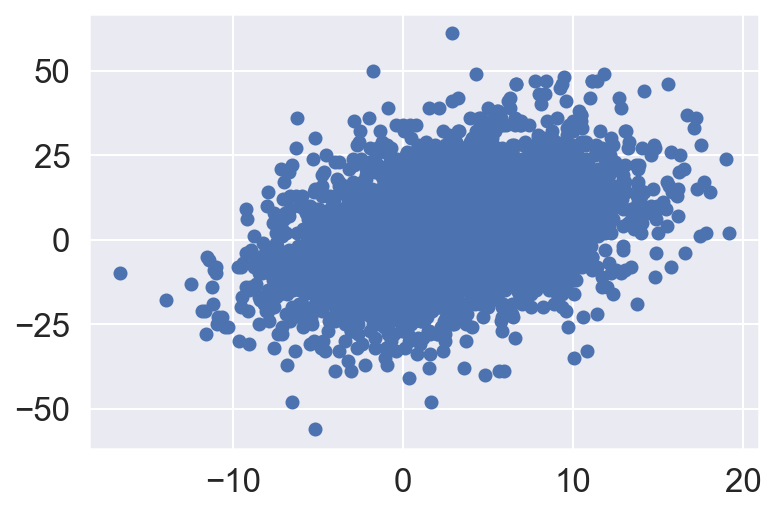

In [14]:
plt.scatter(grid.predict(X_test), yR_test)

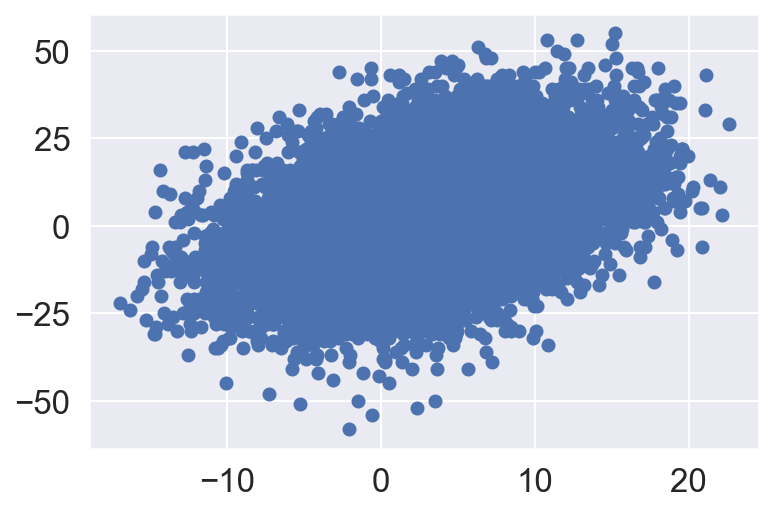

In [11]:
plt.scatter(grid.predict(X_train), yR_train)

In [12]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('model',
                 ElasticNet(alpha=3.0000700000000005, l1_ratio=0.0001,
                            max_iter=1000000))])

In [13]:
grid.best_params_

{'model__alpha': 3.0000700000000005, 'model__l1_ratio': 0.0001}

In [24]:
grid.predict(X_test)

array([ 11.28716519,  -4.54275861,  -9.12192079, ..., -11.3624379 ,
        15.93837787,  10.21672726])

In [26]:
np.array(yR_test)

array([  3,  -1,  -5, ..., -11,  18,  16])

In [14]:
grid.best_estimator_.named_steps['model'].coef_

array([ 3.04070305e-02, -2.85330995e-01,  8.61586227e-02, -1.22042812e-01,
       -4.45421604e-02,  3.71231896e-02,  5.15045745e-02,  8.44387718e-03,
       -3.06270700e-02,  1.17302615e-02, -1.29993634e-03,  1.44083235e-05,
        2.03977812e-02,  3.41468029e-02, -2.53999849e-02, -1.01509359e-03,
        5.26232014e-03, -8.43722499e-03, -2.44876315e-02, -2.67070377e-03,
        2.43741846e-03,  5.71900729e-03, -4.76760471e-03, -1.34480651e-02,
        1.52899999e-03, -4.69825468e-03, -1.49715277e-02, -1.38035573e-02,
        1.29775978e-02, -1.30285636e-03, -4.80117238e-03,  2.88167871e-03,
        1.93278741e-02, -4.76959857e-04, -1.27970575e-03,  1.54994159e-02,
        1.67866702e-02,  1.33031413e-03,  1.10600855e-02, -1.19321901e-03,
       -1.36897156e-02, -7.95286216e-03,  1.83028519e-02,  5.25458334e-03,
       -1.19922585e-02, -7.86405945e-04, -9.98110810e-03, -1.23135937e-02,
       -1.69314918e-02,  2.10463062e-02, -1.08893222e-02,  5.59289752e-03,
        2.41701781e-03, -

In [19]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,739.207520,11.020549,0.043239,0.003716,0.0001,0.0001,"{'model__alpha': 0.0001, 'model__l1_ratio': 0....",-11.895111,-12.289559,-12.161357,-11.875231,-12.290213,-12.102294,0.183495,6
1,388.763274,7.369054,0.046228,0.004125,0.0001,0.10009,"{'model__alpha': 0.0001, 'model__l1_ratio': 0....",-11.895127,-12.289534,-12.161356,-11.875257,-12.290202,-12.102295,0.183478,7
2,383.374015,7.991135,0.045007,0.003306,0.0001,0.20008,"{'model__alpha': 0.0001, 'model__l1_ratio': 0....",-11.895146,-12.289514,-12.161358,-11.875274,-12.290195,-12.102297,0.183464,8
3,396.599155,11.273674,0.041480,0.001611,0.0001,0.30007,"{'model__alpha': 0.0001, 'model__l1_ratio': 0....",-11.895166,-12.289496,-12.161358,-11.875295,-12.290191,-12.102301,0.183450,9
4,422.653876,14.089304,0.044885,0.001575,0.0001,0.40006,"{'model__alpha': 0.0001, 'model__l1_ratio': 0....",-11.895186,-12.289480,-12.161360,-11.875316,-12.290186,-12.102306,0.183436,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.533057,0.009243,0.048170,0.004630,10,0.60004,"{'model__alpha': 10.0, 'model__l1_ratio': 0.60...",-12.970592,-13.416405,-13.116321,-12.953942,-13.132864,-13.118025,0.166080,85
117,0.544083,0.013670,0.048451,0.002502,10,0.70003,"{'model__alpha': 10.0, 'model__l1_ratio': 0.70...",-12.970592,-13.416405,-13.116321,-12.953942,-13.132864,-13.118025,0.166080,85
118,0.536494,0.010688,0.045353,0.002065,10,0.80002,"{'model__alpha': 10.0, 'model__l1_ratio': 0.80...",-12.970592,-13.416405,-13.116321,-12.953942,-13.132864,-13.118025,0.166080,85
119,0.538607,0.008397,0.044971,0.002588,10,0.90001,"{'model__alpha': 10.0, 'model__l1_ratio': 0.90...",-12.970592,-13.416405,-13.116321,-12.953942,-13.132864,-13.118025,0.166080,85


In [23]:
X_train.columns

Index(['h_pg_type', 'h_pg_location', 'h_pg_age_days', 'h_pg_height',
       'h_pg_ewm_seconds', 'h_pg_ewm_fgm', 'h_pg_ewm_fga', 'h_pg_ewm_fg3m',
       'h_pg_ewm_fg3a', 'h_pg_ewm_ftm',
       ...
       'a_pf_fgpct', 'a_pf_gs', 'a_c__fgpct', 'a_c__gs', 'a_s1_fgpct',
       'a_s1_gs', 'a_s2_fgpct', 'a_s2_gs', 'a_s3_fgpct', 'a_s3_gs'],
      dtype='object', length=564)

In [24]:
len(grid.best_estimator_.steps[1][1].coef_)

564

In [17]:
predictions_grad = []
for n in np.concatenate([grid.predict(X_train),grid.predict(X_test)]):
    if n > 0:
        predictions_grad.append(1)
    else:
        predictions_grad.append(0)

true_grad = []
for n in np.concatenate([yR_train,yR_test]):
    if n > 0:
        true_grad.append(1)
    else:
        true_grad.append(0)

true_grad = pd.Series(true_grad, name='Actual')
predictions_grad = pd.Series(predictions_grad, name='Predicted')

df_conf_elcv = pd.crosstab(true_grad, predictions_grad)
df_conf_elcv

Predicted,0,1
Actual,,
0,4224,6023
1,2305,12945


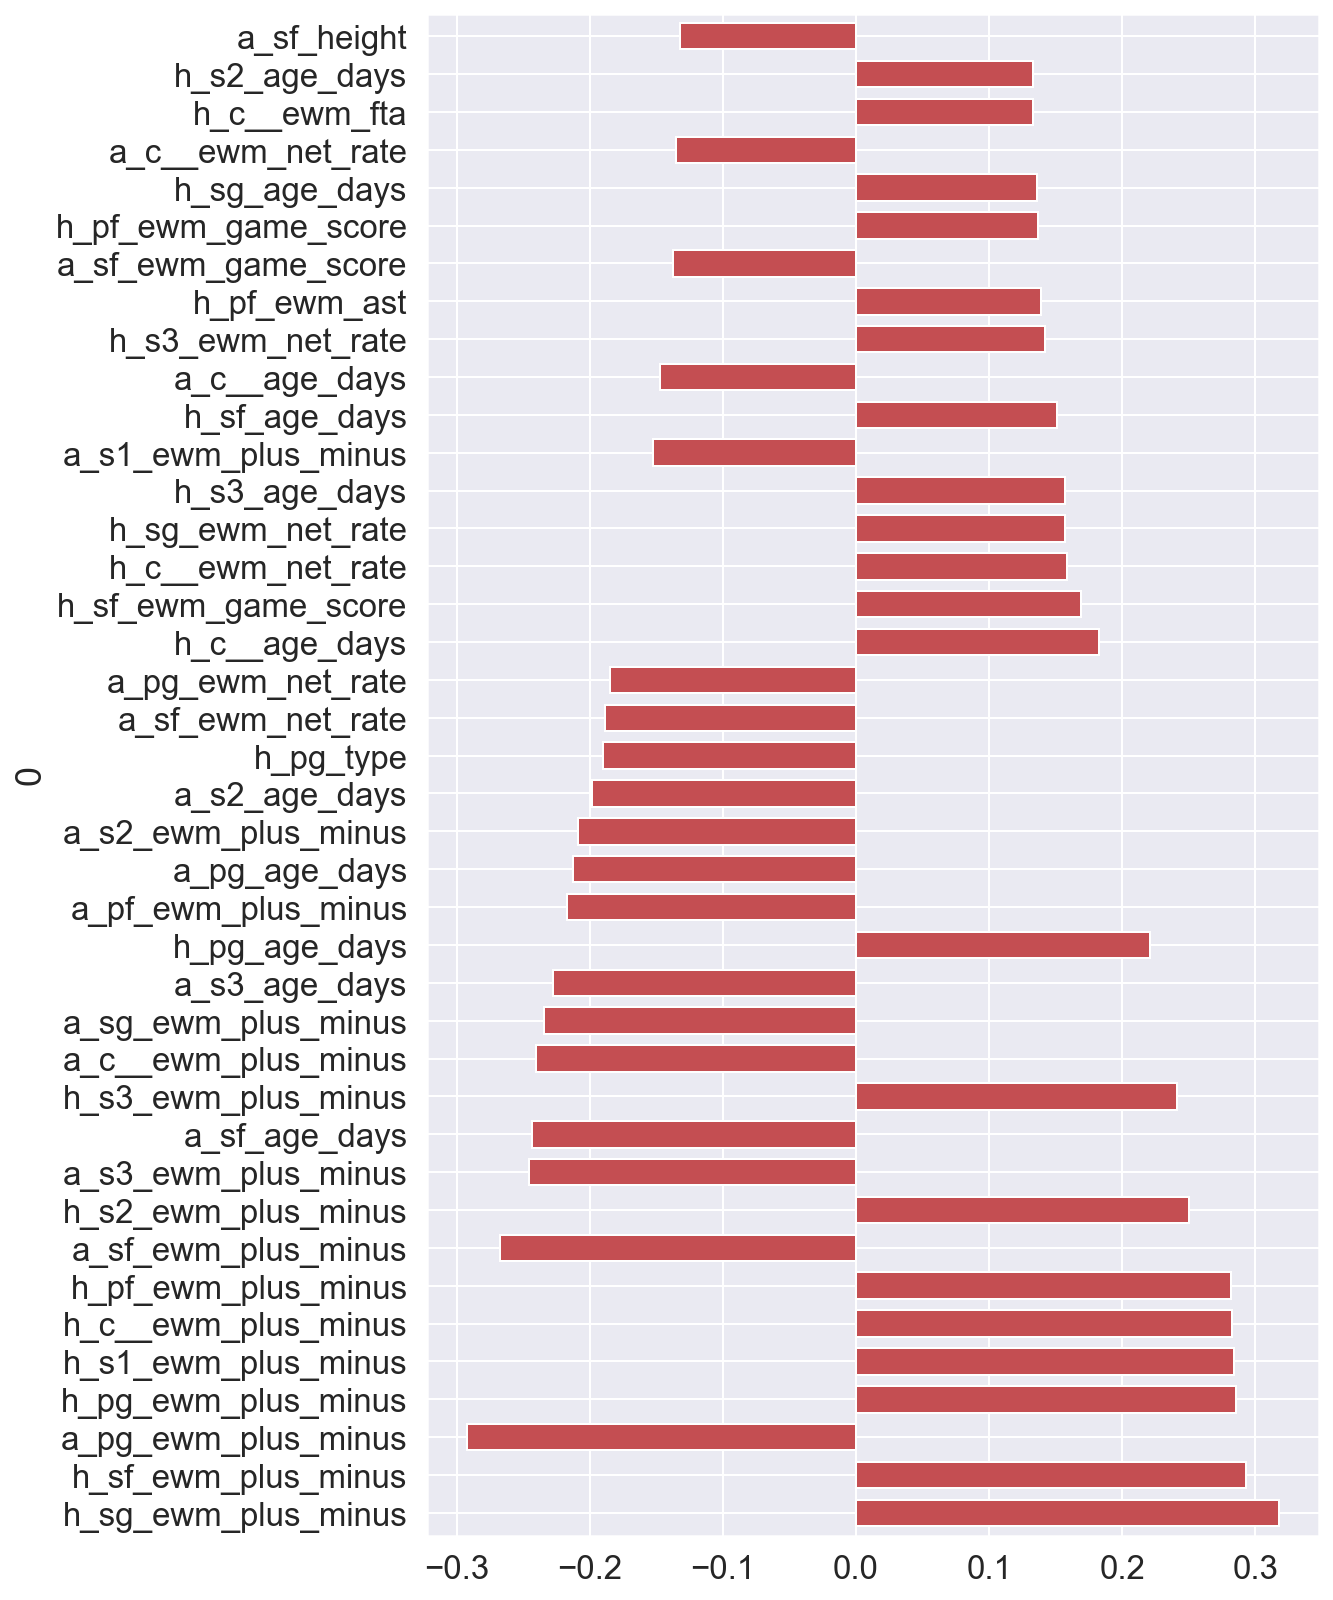

In [28]:
best_coeffs = pd.DataFrame(zip(X_train.columns,grid.best_estimator_.steps[1][1].coef_))
best_coeffs.set_index(0, inplace=True)
best_coeffs.columns = ['coefficients']

best_coeffs['abs_coef'] = best_coeffs.coefficients.apply(abs)

best_coeffs.sort_values(by='abs_coef',
                        ascending=False).head(40)['coefficients'].plot(kind='barh',
                                                                      figsize=(8,14),
                                                                      color='r',
                                                                      width=.7);

In [30]:
grid.get_params()

{'cv': KFold(n_splits=5, random_state=None, shuffle=True),
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('scaler', StandardScaler()),
  ('model', ElasticNet(max_iter=1000000))],
 'estimator__verbose': False,
 'estimator__scaler': StandardScaler(),
 'estimator__model': ElasticNet(max_iter=1000000),
 'estimator__scaler__copy': True,
 'estimator__scaler__with_mean': True,
 'estimator__scaler__with_std': True,
 'estimator__model__alpha': 1.0,
 'estimator__model__copy_X': True,
 'estimator__model__fit_intercept': True,
 'estimator__model__l1_ratio': 0.5,
 'estimator__model__max_iter': 1000000,
 'estimator__model__normalize': False,
 'estimator__model__positive': False,
 'estimator__model__precompute': False,
 'estimator__model__random_state': None,
 'estimator__model__selection': 'cyclic',
 'estimator__model__tol': 0.0001,
 'estimator__model__warm_start': False,
 'estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', ElasticNet(max_it

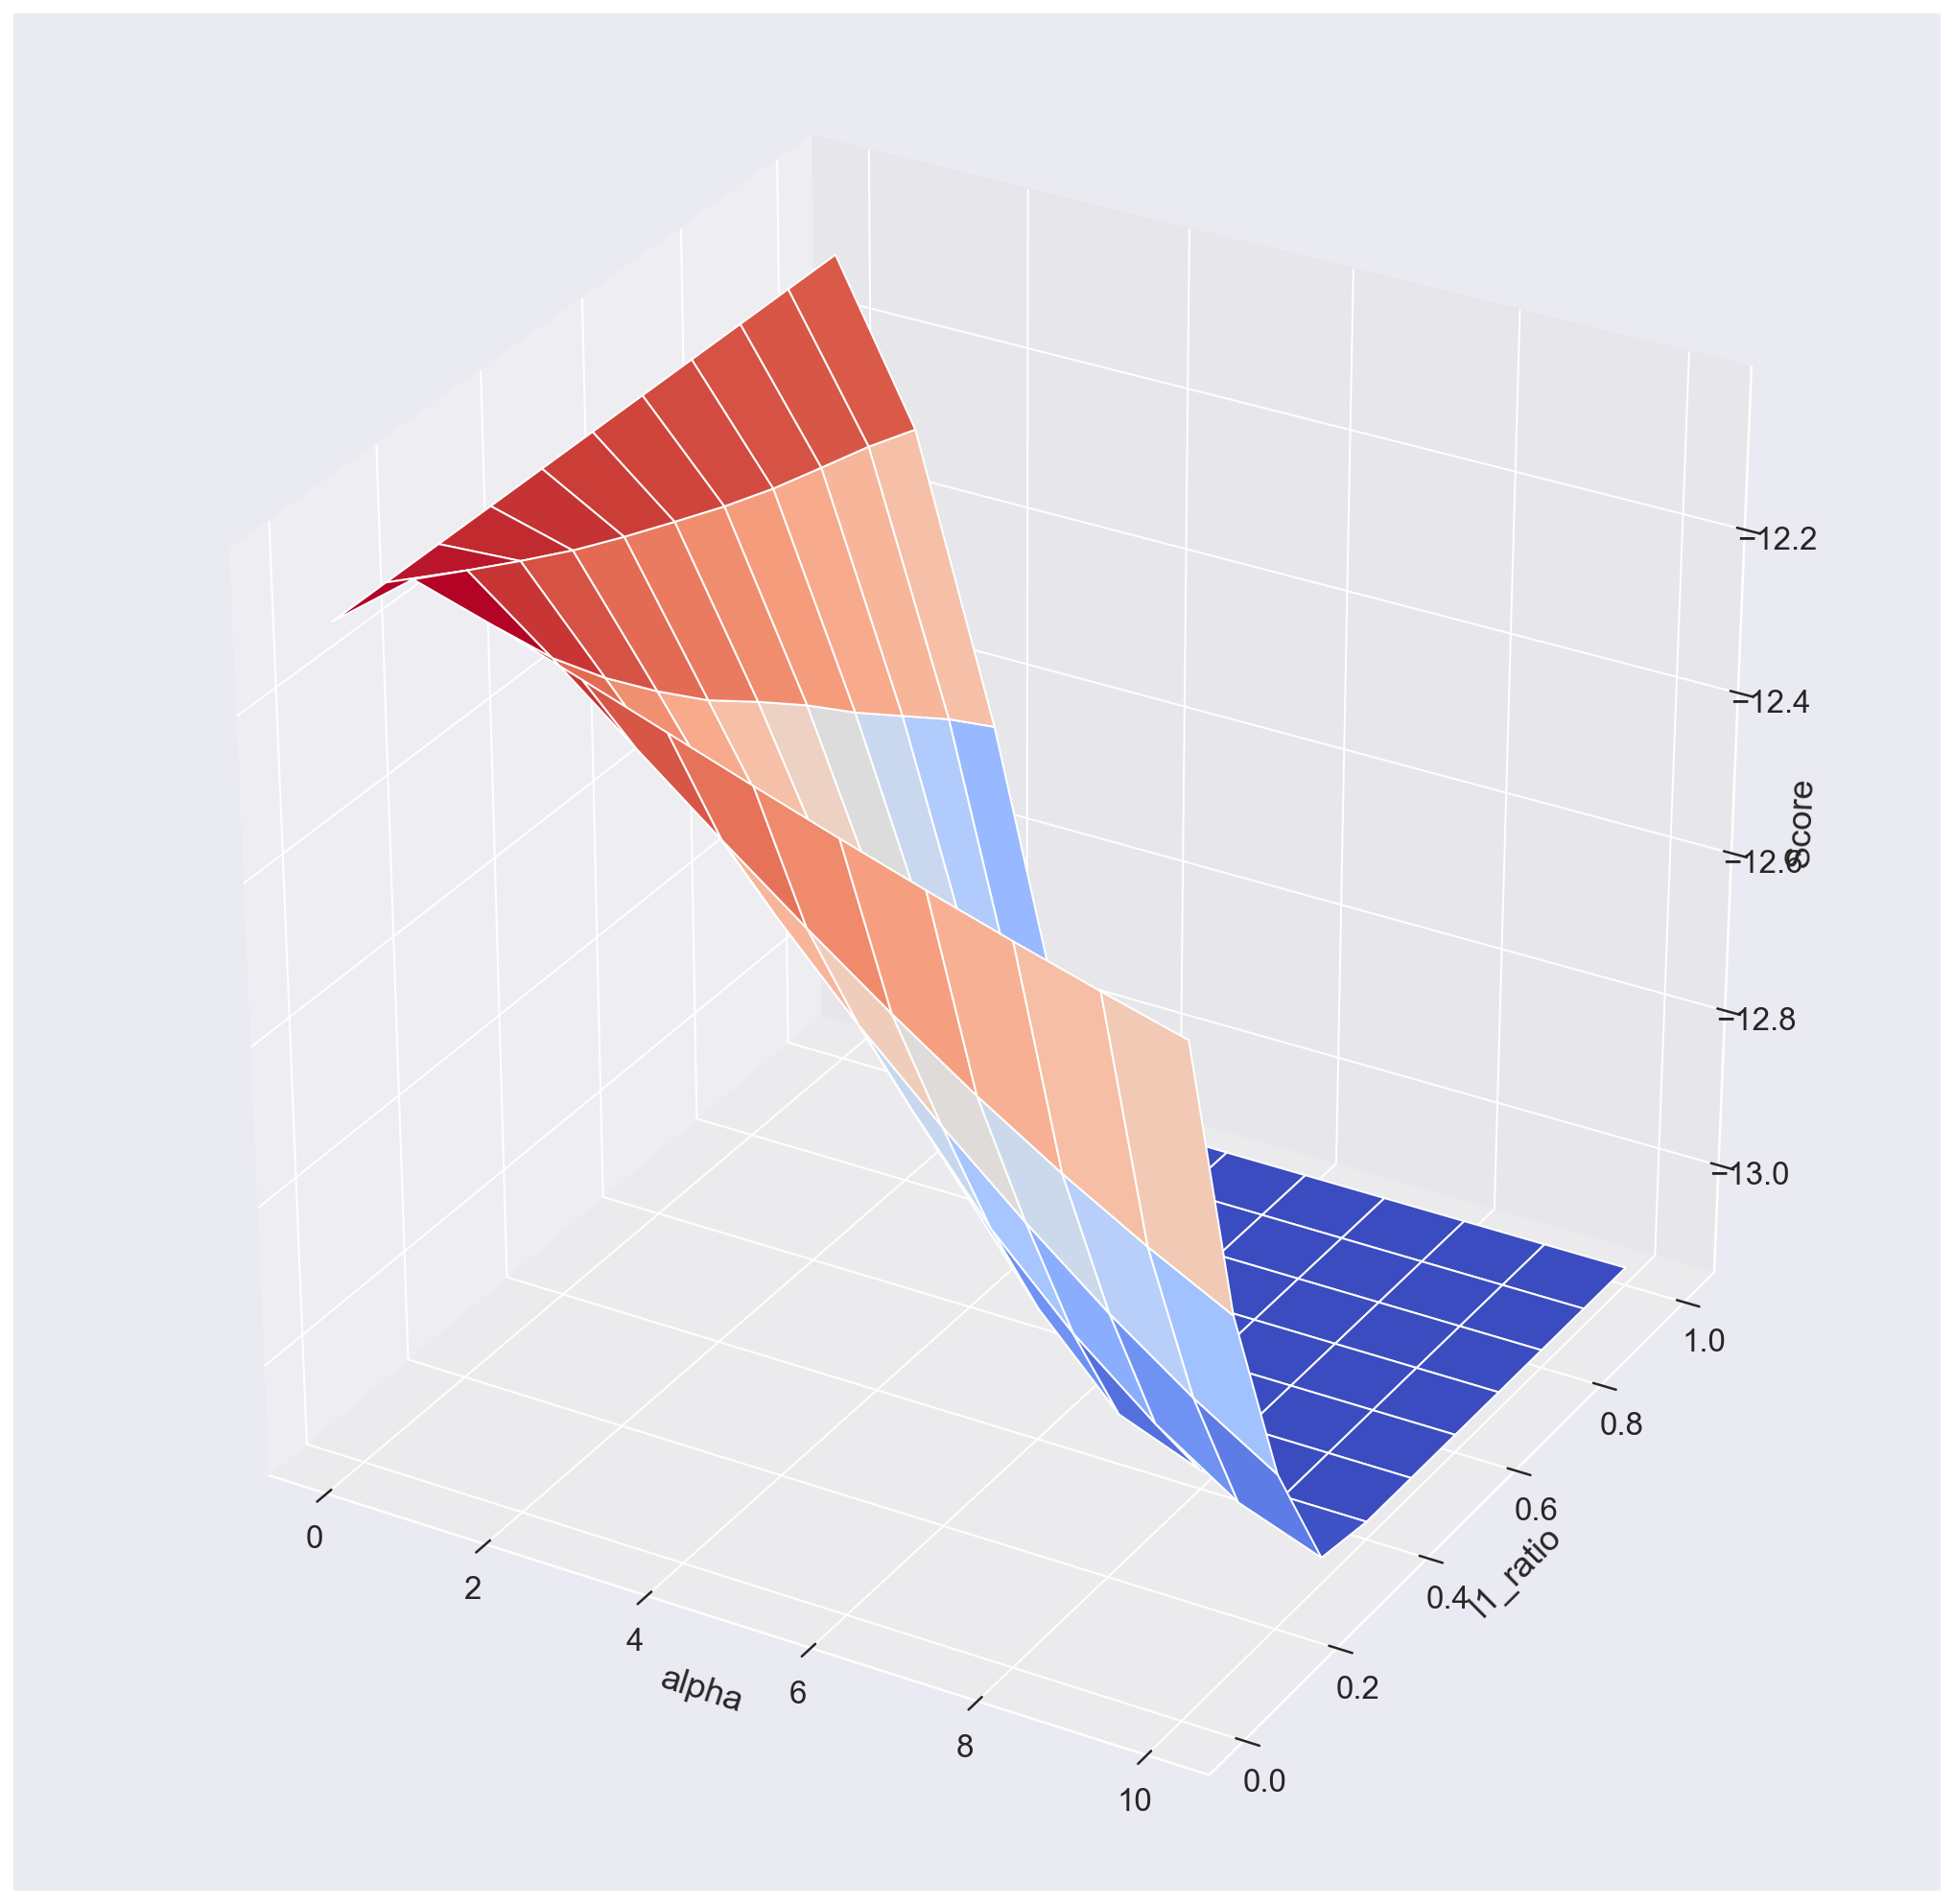

In [36]:
from mpl_toolkits import mplot3d

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, PolyCollection

x_y_z_cols = ['param_model__alpha',
              'param_model__l1_ratio',
              'mean_test_score']

C_values = results[x_y_z_cols[0]]
l1_values = results[x_y_z_cols[1]]
cv_scores = results[x_y_z_cols[2]]


x_plane = np.reshape(np.array(C_values), (11, 11))
y_plane = np.reshape(np.array(l1_values), (11, 11))
z_plane = np.reshape(np.array(cv_scores), (11, 11))
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_plane, y_plane, z_plane, cmap='coolwarm')

# ax.axis('equal')
ax.set_xlabel(x_y_z_cols[0].replace('param_model__',''))
ax.set_ylabel(x_y_z_cols[1].replace('param_model__',''))
ax.set_zlabel('Score')

plt.show()

In [38]:
import joblib
joblib.dump(grid, 'elastic1_non_poly16.jlib')

['elastic1_non_poly16.jlib']